<center><h1>Explore Vaccines Tweets - proxy+Labelled data
   </h1></center>

# Introduction


The Dataset we are using here is collected using Twitter API, **tweepy** and Python package.

The following vaccines are included:  
* Pfizer/BioNTech;   
* Sinopharm;  
* Sinovac;  
* Moderna;  
* Oxford/AstraZeneca;   
* Covaxin;   
* Sputnik V.  



# Data preparation

## Load packages

In [1]:
! pip install tensorflow==2.6 tensorflow-gpu==2.6 seaborn  lightgbm   pandas plotly  matplotlib nltk numpy gensim wordcloud textblob neattext scikit_learn nbformat transformers tensorflow_hub bert-tensorflow  tf-models-official

  Using cached tensorflow-2.6.0-cp38-cp38-manylinux2010_x86_64.whl (458.4 MB)
  Using cached tensorflow_gpu-2.6.0-cp38-cp38-manylinux2010_x86_64.whl (458.4 MB)
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
  Using cached plotly-5.3.1-py2.py3-none-any.whl (23.9 MB)
  Using cached nltk-3.6.5-py3-none-any.whl (1.5 MB)
  Using cached gensim-4.1.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)
  Using cached wordcloud-1.8.1-cp38-cp38-manylinux1_x86_64.whl (371 kB)
  Using cached textblob-0.17.1-py2.py3-none-any.whl (636 kB)
  Using cached neattext-0.1.2-py3-none-any.whl (114 kB)
  Using cached transformers-4.12.3-py3-none-any.whl (3.1 MB)
  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
  Using cached bert_tensorflow-1.0.4-py2.py3-none-any.whl (64 kB)
  Using cached tf_models_official-2.6.0-py2.py3-none-any.whl (1.8 MB)
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3

In [2]:
#! pip install tensorflow==2.6




In [3]:
import numpy as np 
import pandas as pd
import matplotlib as mp
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
##
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
##
import warnings
warnings.simplefilter("ignore")

## Load data

In [4]:
tweets_df = pd.read_csv("tweets_unlabelled_1L_proxy_labels.csv", encoding='utf-8')
train_labelled_df= pd.read_csv("clean_tweets_labelled_train.csv", encoding='utf-8')

In [5]:
tweets_df=tweets_df.append(train_labelled_df)

In [6]:
len(tweets_df)

99147

In [7]:
# seperate off train and test
#train = tweets_df.iloc[90000:, :]
#test = tweets_df.iloc[14469:, :]
train = tweets_df #.sample(frac=0.7,random_state=200)
print(len(train))
#test=tweets_df.drop(train.index)
#print(len(test))


99147



### Classification Tasks

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#import gensim

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix,recall_score,precision_score,make_scorer
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from statistics import mean, stdev
import lightgbm as lgb

import joblib
 


# target variable 
y = train["label"].values

no_of_splits=5
# initializing Kfold
skf = StratifiedKFold(n_splits=no_of_splits, shuffle=True, random_state=24)

# count vectorizer transformation
count_vect = CountVectorizer()
count_vect.fit(tweets_df["clean_data"].values.astype('U').tolist())
train_count_vect = count_vect.transform(train["clean_data"].values.astype('U'))
joblib.dump(count_vect, "model/vectors/count_vect_proxy_labelled.pkl")

# tfidf vectorizer transformation 
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(tweets_df["clean_data"].values.astype('U').tolist())
train_tfidf_vect = tfidf_vect.transform(train["clean_data"].values.astype('U'))
joblib.dump(tfidf_vect, "model/vectors/_tfidf_vect_proxy_labelled.pkl")

['model/vectors/_tfidf_vect_proxy_labelled.pkl']

In [9]:

# light gbm parameters
lgbm_params = {
    "learning_rate": 0.02, 
    "random_state": 24, 
    "metric": "multi_logloss",
    "n_estimators": 2000,
    "objective": "multiclass"
}
# models
models =  {
    "svm": SVC(),
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "SGD": SGDClassifier(),
    "random_forest": RandomForestClassifier(class_weight='balanced'),
    ##"BernoulliNB": BernoulliNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LGBM":lgb.LGBMClassifier(**lgbm_params)
    
} 

# current vectors
vectors = {
    "count_vectorizer": train_count_vect,
    "tfidf_vectorizer": train_tfidf_vect
}

In [10]:
def stratified_kfold(clf:str, vect_type:str, y, kfold):
    """
    Perform Kfold Cross-Validation
    :param model: the model used to make predictions
    :param X: the train features being used 
    :param y: the target feature,
    :param kfold: the cross validation strategy
    :return: dictionary with model name key and results as the values
    """
    results = {}
    # store the name of the model in dictionary
    results["modelname_vectorType"] = clf + "_" + vect_type
    
    # call the model and training data
    model = models[clf]
    X = vectors[vect_type]

    f1score_list= []
    lst_accu_stratified = []
    # perfrom kfold cv
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        #print(f"\nCurrently Training: {results['modelname_vectorType']}... Fold: {fold+1}")
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        # train on seen data, predict on unseen
        model.fit(X_train, y_train)
        y_preds = model.predict(X_valid)
        f1score = f1_score(y_valid, y_preds,average='weighted')
        results["fold_{}".format(fold+1)] = f1score
        lst_accu_stratified.append(model.score(X_valid, y_valid))
        f1score_list.append(f1score)
    results["accuracy"] = "%.3f%%" % (mean(lst_accu_stratified) * 100)
    #results["mean_f1-score"] = "%.3f%%" % (mean(f1score_list)*100)
    # Save the model as a pickle in a file
    joblib.dump(model, "model/"+clf + "_" + vect_type+".pkl")
    return results

In [11]:
def stratified_kfold_lbgm(clf:str, vect_type:str, y, kfold):
    """
    Perform Kfold Cross-Validation
    :param model: the model used to make predictions
    :param X: the train features being used 
    :param y: the target feature,
    :param kfold: the cross validation strategy
    :return: dictionary with model name key and results as the values
    """
    results = {}
    # store the name of the model in dictionary
    results["modelname_vectorType"] = clf + "_" + vect_type
    
    # call the model and training data
    model = models[clf]
    X = vectors[vect_type]
    
    f1score_list= []
    lst_accu_stratified = []
    # perfrom kfold cv
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        print(f"\nCurrently Training: {results['modelname_vectorType']}... Fold: {fold+1}")
        X_train, X_valid= X[train_idx].astype(np.float64), X[valid_idx].astype(np.float64)
        y_train, y_valid= y[train_idx].astype(np.float64), y[valid_idx].astype(np.float64)
        # train on seen data, predict on unseen
        model.fit(X_train,
             y_train,
             eval_set=[(X_valid, y_valid)],
             verbose=100,
             early_stopping_rounds=100)
        
        y_preds = model.predict(X_valid)
        f1score = f1_score(y_valid, y_preds,average='weighted')
        results["fold_{}".format(fold+1)] = f1score
        lst_accu_stratified.append(model.score(X_valid, y_valid))
        f1score_list.append(f1score)


    results["accuracy"] = "%.3f%%" % (mean(lst_accu_stratified) * 100)
    # Save the model as a pickle in a file
    joblib.dump(model, "model/"+clf + "_" + vect_type+".pkl")
    return results

In [12]:
# store all models
all_models = []
for clf in models:
    for vect in vectors:
        if clf == "LGBM":
            all_models.append(stratified_kfold_lbgm(clf, vect, y, skf))
        else:
            all_models.append(stratified_kfold(clf, vect, y, skf))            
        print(f"Current Model: {clf}_{vect}...\n")

Current Model: svm_count_vectorizer...

Current Model: svm_tfidf_vectorizer...

Current Model: logistic_regression_count_vectorizer...

Current Model: logistic_regression_tfidf_vectorizer...

Current Model: naive_bayes_count_vectorizer...

Current Model: naive_bayes_tfidf_vectorizer...

Current Model: SGD_count_vectorizer...

Current Model: SGD_tfidf_vectorizer...

Current Model: random_forest_count_vectorizer...

Current Model: random_forest_tfidf_vectorizer...

Current Model: DecisionTreeClassifier_count_vectorizer...

Current Model: DecisionTreeClassifier_tfidf_vectorizer...

Current Model: KNeighborsClassifier_count_vectorizer...

Current Model: KNeighborsClassifier_tfidf_vectorizer...


Currently Training: LGBM_count_vectorizer... Fold: 1
[100]	valid_0's multi_logloss: 0.197589
[200]	valid_0's multi_logloss: 0.176997
[300]	valid_0's multi_logloss: 0.167126
[400]	valid_0's multi_logloss: 0.160869
[500]	valid_0's multi_logloss: 0.156371
[600]	valid_0's multi_logloss: 0.153067
[700]	

In [13]:
models_df = pd.DataFrame(all_models)
models_df

,modelname_vectorType,fold_1,fold_2,fold_3,fold_4,fold_5,accuracy
0,svm_count_vectorizer,0.941073,0.941555,0.942667,0.943913,0.942524,94.784%
1,svm_tfidf_vectorizer,0.945934,0.943944,0.945600,0.946337,0.945977,95.108%
2,logistic_regression_count_vectorizer,0.940760,0.939436,0.941567,0.942540,0.941445,94.466%
3,logistic_regression_tfidf_vectorizer,0.939070,0.936377,0.938146,0.942239,0.938177,94.477%
4,naive_bayes_count_vectorizer,0.906149,0.906487,0.907762,0.905477,0.906592,90.925%
5,naive_bayes_tfidf_vectorizer,0.864904,0.862854,0.863510,0.864681,0.865364,90.571%
6,SGD_count_vectorizer,0.936706,0.934849,0.934954,0.938026,0.938433,94.206%
7,SGD_tfidf_vectorizer,0.926486,0.921439,0.922414,0.925526,0.924446,93.544%
8,random_forest_count_vectorizer,0.930856,0.932332,0.932504,0.933564,0.933221,93.452%
9,random_forest_tfidf_vectorizer,0.935771,0.934121,0.937586,0.937422,0.934626,94.359%


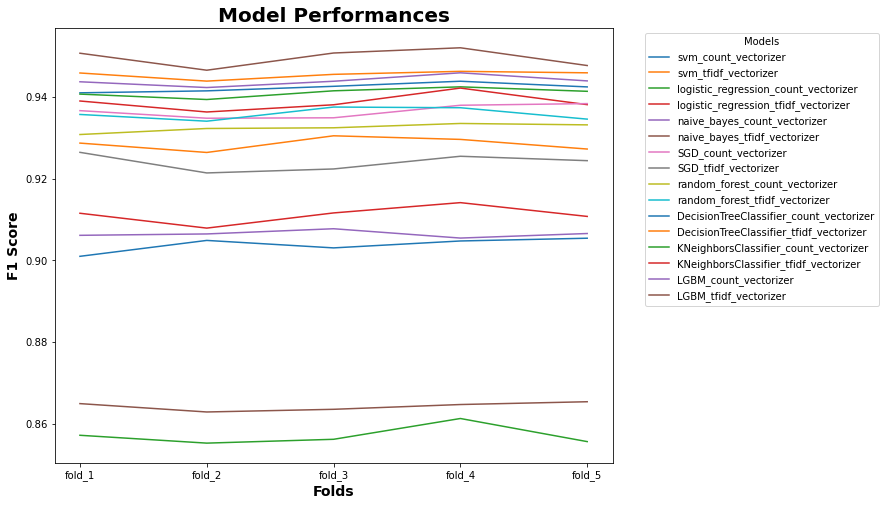

In [14]:
# transposing the dataframe
model_names = models_df["modelname_vectorType"].values
model_names_mappings = dict(zip(range(0, len(model_names)), model_names))
transpose_models_df = models_df.loc[:, "fold_1":"fold_5"].T.rename(columns=model_names_mappings)

x = transpose_models_df.index
fig, ax = plt.subplots(figsize=(10,8))

for model in transpose_models_df.columns:
    plt.plot(x, transpose_models_df[model], label=model)
plt.title("Model Performances", size=20, weight="bold")
plt.xlabel("Folds", size=14, weight="bold")
plt.ylabel("F1 Score", size=14, weight="bold")
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()